# 3. Find similar wines!

In this part, we should implement k-means clustering algorithm on the wine dataset from scratch.

First of all, we downloaded the dataset from the given link and converting the dataset to a dataframe. 

By considering the dataset, we have 3 functions silhouette score for finding the optimal number of clusters, K-means algorithm and Rand index for compute similarity between two results, respectively.

## Libraries : 

In [1]:
import pandas as pd
import random as rnd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import math

## Import data :
Read the downloaded dataset and convert to dataframe for better parsing.

In [2]:
d = pd.read_csv(r"F:\Data Scinece\ADM\HomeWork\4\data set\wine.csv")
df = pd.DataFrame(d)

# name the columns based on the information in the provided link

df.columns = ["class identifier","Alcohol","Malic acid","Ash","Alcalinity of ash","Magnesium","Total phenols",
            "Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue",
            "OD280/OD315 of diluted wines","Proline"]

## Finding optimal number of clusters by using silhouette score :
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Here is the function that calculate the optimal number of clusters based on this method:

In [13]:
# Use silhouette score to find optimal number of clusters:

def n_cluster(df,A,B):
    
    # range of number of clusters for analysing
    num_clusters = np.arange(2,10)
    
    results = {}
    # filter selected features for clustering
    data = df[[A,B]].copy()
    
    for size in num_clusters:
        
        # Fitting K-Means to the dataset
        model = KMeans(n_clusters = size).fit(data)
        predictions = model.predict(data)
        
        # Compute the silhouette scores for each sample
        results[size] = silhouette_score(data, predictions)
    best_size = max(results,key=results.get)
    
    return best_size

## K-means Algorithm Function :
The K-means algorithm starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative calculations to optimize the positions of the centroids.

In this algorithm, the inputs of function is main dataset, the 2 features selected for analyzing and number of clusters which that provided from previous function. For initial centroids, we use this approach:

    1.pick the first point at random
    2.WHILE there are fewer than k points DO
        Add the point whose minimum distance from the selected points is as large as possible;
    END
In next step, we compute Euclidean distance of all point to centroids, and put each point to the cluster which its centroid has minimum distance to the point. 

After that, calculate new centroid based on the clusters and again allocate points to them.
we repeat this step untill we see no changes in the clusters.


In [5]:

def k_means(df,A,B,K):
    # filter the dataset based on the selected features 
    df = df[[A,B]].copy()
    n = len(df)
    # select a random points as first centroid
    R = rnd.randrange(0,n-1)
    # put the information of centroids in a list
    k_list = [df.iloc[R]]
    
    i = 0
    distance = pd.DataFrame()

    while len(k_list) < K :

        point = k_list[i]
        # calculate Euclidean distance of centroids from points
        new_df = df.apply(lambda x : (x - point)**2 , axis = 1)
        distance[i] = new_df.sum(axis = 1).apply(lambda x : x**(1/2))
        
        # select the point with minmax distance as a new centroid
        new_k = (distance.min(axis = 1)).idxmax()
        k_list.append(df.iloc[new_k])
        i += 1
        
    dist = pd.DataFrame()

    for i in range(len(k_list)) :
            # calculate the Euclidean distance of centroid from other points
            point = k_list[i]
            new_df = df.apply(lambda x : (x - point)**2 , axis = 1)
            dist[i] = new_df.sum(axis = 1).apply(lambda x : x**(1/2))
    
    # allocate points to clusters based on minimum distance from centroids
    cluster = dist.idxmin(axis = 1)
   
    df["cluster"] = cluster
    
    # create a dataframe to save the previous result of clustering
    cluster_pre = pd.Series(np.zeros(len(df)))
    
    # we repeat calculating distance and finding new centorids and new clusters untill the provided result was exactly the same 
    # with the previous one
    while cluster.equals(cluster_pre) == False :
        
        #calculate the centroid from the cluster by getting the position of all points of a single cluster, sum them up 
        #and divide by the number of points.(mean)
        centroid = df.groupby("cluster").mean()
        df = df.drop(['cluster'], axis=1)

        for i in range(len(centroid)):
            k_list[i] = centroid.iloc[i]

        for i in range(len(k_list)) :

            point = k_list[i]
            new_df = df.apply(lambda x : (x - point)**2 , axis = 1)
            dist[i] = new_df.sum(axis = 1).apply(lambda x : x**(1/2))

        cluster_pre = cluster    
        cluster = dist.idxmin(axis = 1)
        df["cluster"] = cluster
        return df, centroid

## Finding Similarity between results by Rand Index :
Rand Index is a measure of the similarity between two data clusterings.

Given a set of n elements S=\{o1,...,on} and two partitions of S to compare, X={X1,..., Xr}, a partition of S into r subsets, and Y={Y1,..., Ys}, a partition of S into s subsets, define the following:

    a: the number of pairs of elements in S that are in the same subset in X and in the same subset in Y
    b: the number of pairs of elements in S that are in different subsets in X and in different subsets in Y
The Rand index, R is:

        R= (a+b)/(n!/2*(n-2)!)

In [6]:
def Rand_index(df ,df1):
    # finding "a" based on the explanation
    tuple_A = 0
    # finding "b" based on the explanation
    tuple_B = 0
    n = len(df)
    for j in range(n - 1):
        for h in range(j + 1, n):
            
            if df['cluster'].iloc[j] == df['cluster'].iloc[h] and df1['cluster'].iloc[j] == df1['cluster'].iloc[h]:
                tuple_A += 1
                
            elif df['cluster'].iloc[j] != df['cluster'].iloc[h] and df1['cluster'].iloc[j] != df1['cluster'].iloc[h]:
                tuple_B += 1

    Similarity =round((tuple_A + tuple_B)*100 / (math.factorial(n)/(2 * math.factorial(n-2))))
    
    print('Similarity between 2 clusters equals to %s%%'%(Similarity))

## Ploting distributions for features :

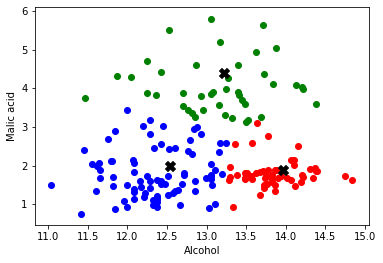

In [14]:
# calculate the number of clusters with the function
K = n_cluster(df,"Alcohol","Malic acid")

#calculate k-means with function
data, centroid = k_means(df,"Alcohol","Malic acid",K)

#ploting the distribution
color = ['blue','green','red','yellow','crimson','aqua','chocolate','coral','plum','maroon']
for k in range(K):
    d = data[data["cluster"] == k]
    plt.scatter(d["Alcohol"],d["Malic acid"],c = color[k])
plt.scatter(centroid["Alcohol"],centroid["Malic acid"],c = 'black', marker = 'X',s = 100) #Centroids
plt.xlabel('Alcohol')
plt.ylabel('Malic acid')
plt.show()

## Calculating similarity between results : 
Based on the results which provided by repeating the functions, we can see that clusters are very similar too each other.

In [15]:
data1, x = k_means(df,"Alcohol","Malic acid",K)
Rand_index(data, data1)

Similarity between 2 clusters equals to 88%


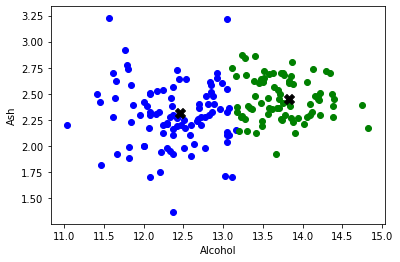

In [16]:
K = n_cluster(df,"Alcohol","Ash")
data, centroid = k_means(df,"Alcohol","Ash",K)

color = ['blue','green','red','yellow','crimson','aqua','chocolate','coral','plum','maroon']
for k in range(K):
    d = data[data["cluster"] == k]
    plt.scatter(d["Alcohol"],d["Ash"],c = color[k])
plt.scatter(centroid["Alcohol"],centroid["Ash"],c = 'black', marker = 'X',s = 100) #Centroids
plt.xlabel('Alcohol')
plt.ylabel('Ash')
plt.show()

Similarity between 2 clusters equals to 99%


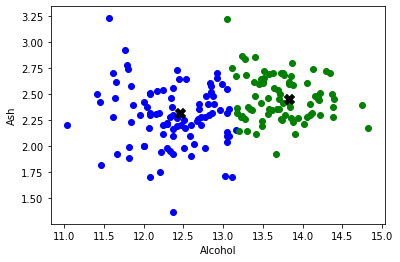

In [17]:
data1, x = k_means(df,"Alcohol","Ash",K)
Rand_index(data, data1)
color = ['blue','green','red','yellow','crimson','aqua','chocolate','coral','plum','maroon']
for k in range(K):
    d = data1[data1["cluster"] == k]
    plt.scatter(d["Alcohol"],d["Ash"],c = color[k])
plt.scatter(centroid["Alcohol"],centroid["Ash"],c = 'black', marker = 'X',s = 100) #Centroids
plt.xlabel('Alcohol')
plt.ylabel('Ash')
plt.show()